In [12]:
import pandas as pd
import scipy.stats as stats
import bioframe as bf
import numpy as np
import csv
from collections import defaultdict
from Bio import SeqIO
import os
import json

import matplotlib.pyplot as plt

# Selecting affected genes
The files used for execution are too large for upload, so instead the processed bioframes are saved. 

The original files can be made available upon request.

<BarContainer object of 2 artists>

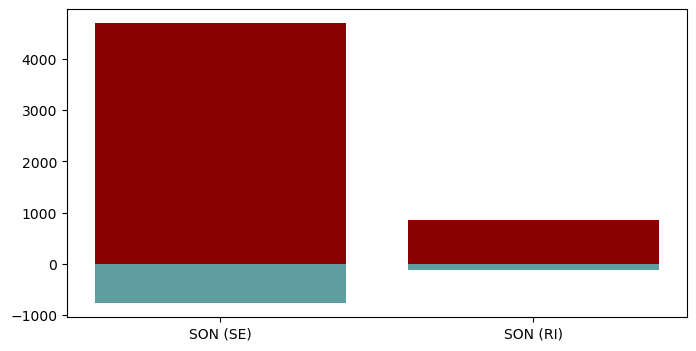

In [13]:
# son_pA_rmats_SE_path = ".../HCT116_SON_Protac_pA_mRNA/rMATS_manual_SONpA_fr-firststrand/SE.MATS.JC.txt"
# son_pA_rmats_RI_path = ".../HCT116_SON_Protac_pA_mRNA/rMATS_manual_SONpA_fr-firststrand/RI.MATS.JC.txt"
son_pA_rmats_SE = pd.read_csv(son_pA_rmats_SE_path, sep="\t")
son_pA_rmats_RI = pd.read_csv(son_pA_rmats_RI_path, sep="\t")
son_pA_rmats_SE.sort_values(by="FDR", inplace=True)
son_pA_rmats_RI.sort_values(by="FDR", inplace=True)

fig = plt.figure(figsize=(8,4))
son_skipped_exon = son_pA_rmats_SE[(son_pA_rmats_SE.FDR < 0.05) & (son_pA_rmats_SE.IncLevelDifference > 0.2)]
son_unskipped_exon = son_pA_rmats_SE[(son_pA_rmats_SE.FDR < 0.05) & (son_pA_rmats_SE.IncLevelDifference < -0.2)]
son_retained_intron = son_pA_rmats_RI[(son_pA_rmats_RI.FDR < 0.05) & (son_pA_rmats_RI.IncLevelDifference < -0.2)]
son_unretained_intron = son_pA_rmats_RI[(son_pA_rmats_RI.FDR < 0.05) & (son_pA_rmats_RI.IncLevelDifference > 0.2)]

x=[0,1]
plt.bar(x, [len(son_skipped_exon), len(son_retained_intron),], color='darkred', tick_label=['SON (SE)','SON (RI)'])
plt.bar(x, [-len(son_unskipped_exon), -len(son_unretained_intron),], color='cadetblue', tick_label=['SON (SE)','SON (RI)'])


In [14]:
son_dep_exons = son_skipped_exon[["chr", "exonStart_0base", "exonEnd", "geneSymbol", "strand"]].rename(columns={"chr":"chrom", "exonStart_0base":"start", "exonEnd":"end", "geneSymbol":"name"})
son_dep_exons_bf = bf.from_any(son_dep_exons)

son_dep_introns = son_retained_intron[["chr", "riExonStart_0base", "riExonEnd", "geneSymbol", "strand"]].rename(columns={"chr":"chrom", "riExonStart_0base":"start", "riExonEnd":"end", "geneSymbol":"name"})
son_dep_introns_bf = bf.from_any(son_dep_introns)

In [15]:
son_dep_genes_set = set(list(son_dep_exons_bf.name.unique()) + \
                    list(son_dep_introns_bf.name.unique()))

len(son_dep_genes_set)

2105

# Filtering the affected genes

## affected genes, that are also robustly expressed

In [16]:
# deseq_counts = pd.read_csv('.../HCT116_SON_SRRM2_double_pA_mRNA/DESeq2_samples.SONdep/DEseq_basic_counts_DESeq2.normalized.tsv',
                           sep='\t',
                           index_col=0)
# deseq_lfc = pd.read_csv('.../HCT116_SON_SRRM2_double_pA_mRNA/DESeq2_samples.SONdep/DEseq_basic_DEresults_LFCshrunk.tsv',
                           sep='\t',
                           index_col=0)

deseq_counts['control_mean'] = deseq_counts[['control_rep1', 'control_rep2', 'control_rep3']].mean(axis=1)
deseq_counts['SONdep_mean'] = deseq_counts[['SONdep_rep1', 'SONdep_rep2', 'SONdep_rep3']].mean(axis=1)

deseq_lfc = pd.merge(deseq_lfc, deseq_counts[["control_mean", 'SONdep_mean']], left_index=True, right_index=True)
expressed_genes = deseq_lfc[deseq_lfc['control_mean'] > 200]['external_gene_name']
expressed_genes.head()

ENSG00000000003.14      TSPAN6
ENSG00000000419.12        DPM1
ENSG00000000457.13       SCYL3
ENSG00000000460.16    C1orf112
ENSG00000001036.13       FUCA2
Name: external_gene_name, dtype: object

<BarContainer object of 2 artists>

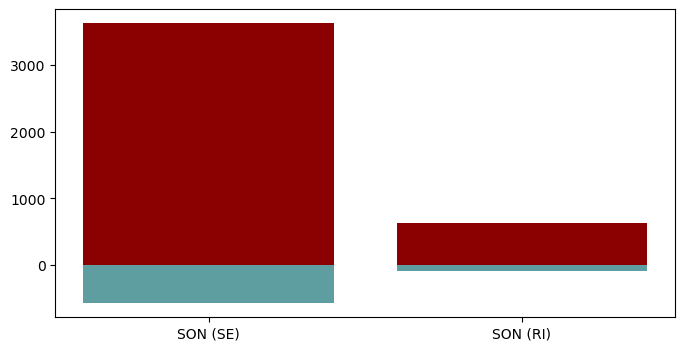

In [17]:
son_skipped_exon_expressed = son_pA_rmats_SE[(son_pA_rmats_SE['GeneID'].isin(expressed_genes.index)) & 
                                    (son_pA_rmats_SE.FDR < 0.05) & 
                                    (son_pA_rmats_SE.IncLevelDifference > 0.2)]

son_unskipped_exon_expressed = son_pA_rmats_SE[(son_pA_rmats_SE['GeneID'].isin(expressed_genes.index)) &
                                     (son_pA_rmats_SE.FDR < 0.05) & 
                                     (son_pA_rmats_SE.IncLevelDifference < -0.2)]

son_retained_intron_expressed = son_pA_rmats_RI[(son_pA_rmats_RI['GeneID'].isin(expressed_genes.index)) &
                                      (son_pA_rmats_RI.FDR < 0.05) & 
                                      (son_pA_rmats_RI.IncLevelDifference < -0.2)]

son_unretained_intron_expressed = son_pA_rmats_RI[(son_pA_rmats_RI['GeneID'].isin(expressed_genes.index)) &
                                        (son_pA_rmats_RI.FDR < 0.05) & 
                                        (son_pA_rmats_RI.IncLevelDifference > 0.2)]

fig = plt.figure(figsize=(8,4))
x=[0,1]
plt.bar(x, [len(son_skipped_exon_expressed), len(son_retained_intron_expressed),], color='darkred', tick_label=['SON (SE)','SON (RI)'])
plt.bar(x, [-len(son_unskipped_exon_expressed), -len(son_unretained_intron_expressed),], color='cadetblue', tick_label=['SON (SE)','SON (RI)'])

## affected, expressed genes that are in speckle domains

In [18]:
def process_attribs(attribs):
    new_attribs = {}
    attribs = list(filter(None, attribs.split(';'))) ## removes empty strings, needed because some gff3 lines have ";;"
    attribs = [x.strip() for x in attribs] # removing spaces at the beginning
    for attrib in attribs:
        k, v = attrib.split(' ')
        new_attribs[k] = v.strip('"')
    return new_attribs

def get_name(row):
    attributes = process_attribs(row['attributes'])
    return attributes['gene_id']

def get_type(row):
    attributes = process_attribs(row['attributes'])
    return attributes['gene_type']


#gencodev29 = bf.read_table(".../genomes/human/snakepipes/hg38/GRCh38_gencode_release29/annotation/genes.gtf",
                        schema='gtf',
                          comment='#')

gencodev29 = gencodev29[gencodev29['feature'] == 'gene']
gencodev29['name'] = gencodev29.apply(lambda row: get_name(row), axis=1)
gencodev29['type'] = gencodev29.apply(lambda row: get_type(row), axis=1)


gencodev29 = gencodev29[(gencodev29['type'] == 'protein_coding')]

#hg38_fasta = bf.load_fasta(".../genomes/human/snakepipes/hg38/GRCh38_gencode_release29/genome_fasta/genome.fa")
gencodev29_gc = bf.frac_gc(gencodev29[['chrom', 'start', 'end', 'strand', 'name']], hg38_fasta)
gencodev29_gc['gene_length'] = gencodev29_gc.end - gencodev29_gc.start

gencodev29_gc.head()

chrom   start     end strand                name        GC  gene_length
57    chr1   65419   71585      +   ENSG00000186092.6  0.320467         6166
315   chr1  450703  451697      -   ENSG00000284733.1  0.456740          994
443   chr1  685679  686673      -   ENSG00000284662.1  0.456740          994
714   chr1  923928  944581      +  ENSG00000187634.11  0.665811        20653
1071  chr1  944204  959309      -  ENSG00000188976.10  0.595432        15105

In [19]:
#k562_spin = pd.read_csv(".../HCT116_SON_Protac_Cyto_mRNA/compartments/K562_SPIN_25kb_hg38.bed",
                        sep="\t",
                       skiprows=1,
                       names = ["chrom", "start", "end", "name", 'A' 'B', 'C', 'D', 'E', 'F'])

k562_spin = k562_spin[['chrom', 'start', 'end', 'name']]
k562_spin_bf = bf.from_any(k562_spin)
k562_spin_bf.head()

chrom    start      end            name
0  chr1   875000  2550000         Speckle
1  chr1  2550000  2650000   Interior_Act1
2  chr1  2650000  2800000  Interior_Repr1
3  chr1  2800000  2925000   Interior_Act1
4  chr1  2925000  3075000  Interior_Repr1

In [20]:
gencodev29_gc_spin = bf.overlap(gencodev29_gc, k562_spin_bf)
gencodev29_gc_spin.rename(columns = {'name_':'SPIN states'}, inplace=True)
gencodev29_gc_spin = gencodev29_gc_spin.drop_duplicates(subset=['chrom', 'start', 'end', 'strand'])
gencodev29_gc_spin.head()

chrom   start     end strand                name        GC  gene_length  \
0  chr1   65419   71585      +   ENSG00000186092.6  0.320467         6166   
1  chr1  450703  451697      -   ENSG00000284733.1  0.456740          994   
2  chr1  685679  686673      -   ENSG00000284662.1  0.456740          994   
3  chr1  923928  944581      +  ENSG00000187634.11  0.665811        20653   
4  chr1  944204  959309      -  ENSG00000188976.10  0.595432        15105   

  chrom_  start_     end_ SPIN states  
0   None    <NA>     <NA>        None  
1   None    <NA>     <NA>        None  
2   None    <NA>     <NA>        None  
3   chr1  875000  2550000     Speckle  
4   chr1  875000  2550000     Speckle

In [21]:
son_dep_exons = son_skipped_exon_expressed[["chr", "exonStart_0base", "exonEnd", "geneSymbol", "strand"]].rename(columns={"chr":"chrom", "exonStart_0base":"start", "exonEnd":"end", "geneSymbol":"name"})
son_dep_exons_bf = bf.from_any(son_dep_exons)

son_dep_introns = son_retained_intron_expressed[["chr", "riExonStart_0base", "riExonEnd", "geneSymbol", "strand"]].rename(columns={"chr":"chrom", "riExonStart_0base":"start", "riExonEnd":"end", "geneSymbol":"name"})
son_dep_introns_bf = bf.from_any(son_dep_introns)

speckle_skipped_exon = bf.overlap(son_dep_exons_bf, gencodev29_gc_spin)
speckle_skipped_exon = speckle_skipped_exon[speckle_skipped_exon["SPIN states_"].isin(["Speckle", "Interior_Act1"])]
speckle_skipped_exon.head()


chrom      start        end   name strand chrom_     start_       end_  \
0  chrX  154485770  154485979  UBL4A      -   chrX  154483717  154486670   
1  chrX  154485770  154486083  UBL4A      -   chrX  154483717  154486670   
2  chrX  154352552  154352675   FLNA      -   chrX  154348524  154374638   
3  chrX  154365348  154365486   FLNA      -   chrX  154348524  154374638   
4  chrX  154366023  154366224   FLNA      -   chrX  154348524  154374638   

  strand_               name_       GC_  gene_length_ chrom__    start__  \
0       -  ENSG00000102178.12  0.611920        2953.0    chrX  154300000   
1       -  ENSG00000102178.12  0.611920        2953.0    chrX  154300000   
2       -  ENSG00000196924.15  0.622769       26114.0    chrX  154300000   
3       -  ENSG00000196924.15  0.622769       26114.0    chrX  154300000   
4       -  ENSG00000196924.15  0.622769       26114.0    chrX  154300000   

       end__ SPIN states_  
0  154600000      Speckle  
1  154600000      Speckle  
2  154600000      Speckle  
3  154600000      Speckle  
4  154600000      Speckle

## saving the processed bioframes
original, whole genome data files are too large for upload, so I'm saving the processed bioframes

In [31]:
son_dep_exons_bf.to_csv("data/son_dep_exons_bf.csv.gz")
son_dep_introns_bf.to_csv("data/son_dep_introns_bf.csv.gz")
speckle_skipped_exon.to_csv("data/speckle_skipped_exon_bf.csv.gz")

## selecting the genes for ExOrthist

In [22]:
speckle_retained_intron = bf.overlap(son_dep_introns_bf,gencodev29_gc_spin)
speckle_retained_intron = speckle_retained_intron[speckle_retained_intron["SPIN states_"].isin(["Speckle", "Interior_Act1"])]

speckle_retained_intron.head()

chrom      start        end     name strand chrom_     start_       end_  \
0  chrX  153913217  153913600  ARHGAP4      -   chrX  153907367  153934999   
2  chrX   49076644   49077911    WDR45      -   chrX   49071470   49101170   
3  chrX   48814674   48814893    HDAC6      +   chrX   48801377   48824982   
4  chrX   48814961   48815490    HDAC6      +   chrX   48801377   48824982   
5  chrX   48818040   48818412    HDAC6      +   chrX   48801377   48824982   

  strand_               name_       GC_  gene_length_ chrom__    start__  \
0       -  ENSG00000089820.15  0.581427         27632    chrX  153400000   
2       -  ENSG00000196998.17  0.509259         29700    chrX   48650000   
3       +  ENSG00000094631.19  0.505571         23605    chrX   48650000   
4       +  ENSG00000094631.19  0.505571         23605    chrX   48650000   
5       +  ENSG00000094631.19  0.505571         23605    chrX   48650000   

       end__ SPIN states_  
0  154150000      Speckle  
2   49250000      Speckle  
3   49250000      Speckle  
4   49250000      Speckle  
5   49250000      Speckle

In [23]:
print("skipped exon: ",len(speckle_skipped_exon.name.unique()))
print("retained intron: ", len(speckle_retained_intron.name.unique()))
son_dependent_genes_filtered = set(speckle_skipped_exon.name.unique()) | set(speckle_retained_intron.name.unique())
print("total: ", len(son_dependent_genes_filtered)) 

skipped exon:  1136
retained intron:  371
total:  1211


## selecting only GC rich genes

In [25]:
print("skipped exon: ",len(speckle_skipped_exon[speckle_skipped_exon['GC_'] > 0.5].name.unique()))
print("retained intron: ", len(speckle_retained_intron[speckle_retained_intron['GC_'] > 0.5]
.name.unique()))
son_dependent_genes = set(speckle_skipped_exon[speckle_skipped_exon['GC_'] > 0.5].name.unique()) | set(speckle_retained_intron[speckle_retained_intron['GC_'] > 0.5]
.name.unique())
print("total: ", len(son_dependent_genes)) 

skipped exon:  961
retained intron:  329
total:  1026


# downloading NCBI orthologs of affected genes

I need now to download the DNA sequences and GTF files from some orthology database. Filter to have only:
- straight orthologs (no paralogs)
- same number of exons
- same length of exons?

downloading the ncbi datasets with v13 (DNA, RNA and protein)
```bash
while read -r gene; do
    datasets download ortholog symbol $gene --filename ${gene}.zip
    unzip ${gene}.zip && mv ncbi_dataset $gene && rm ${gene}.zip
    mv README.md $gene
    done < son_dep_genes_lst.txt
    ```

In [31]:
downloaded_orthologs = os.listdir("orthologs/ncbi")

not_found = set(son_dependent_genes) - set(downloaded_orthologs)
len(not_found)

25

NCBI orthology database didn't have information for 25 genes, but still have 1001 to work with. Good.

# Selecting genomes

I need to select which genomes I will download and run ExOrthist on. 
* All the genomes should have orthologs of affected genes annotated
* Genomes should span most interesting taxonomic groups (FISH, AMPHIBIANS, REPTILES, BIRDS, MAMMALS)
* cannot have too many genomes, because it would drive the analysis into infinity

The NCBI orthologs can be downloaded from the NCBI datasets, using the code above. They won't be uploaded here, because they are too large.


In [ ]:
data = pd.read_json("orthologs/ncbi/AUP1/data/data_report.jsonl", lines=True)
data['assembly_ID'] = [x[0]['assembliesInScope'][0]['accession'] if x == x else np.nan for x in data.annotations]
genomes = [x[0]['assembliesInScope'][0]['accession'] for x in data.annotations if x == x ]
taxids = data[data['assembly_ID'].isin(genomes)]["taxId"]
taxnames = data[data['assembly_ID'].isin(genomes)]["taxname"]

for folder in filter(os.path.isdir, os.listdir('orthologs/ncbi')):
    if folder == 'datasets_v16': continue
    else:
        data = pd.read_json("orthologs/ncbi/{}/data/data_report.jsonl".format(folder), lines=True)
        data['assembly_ID'] = [x[0]['assembliesInScope'][0]['accession'] if x == x else np.nan for x in data.annotations]
        new_genomes = [x[0]['assembliesInScope'][0]['accession'] for x in data.annotations if x == x ]
        new_taxids = data[data['assembly_ID'].isin(new_genomes)]["taxId"]
        new_taxnames = data[data['assembly_ID'].isin(new_genomes)]["taxname"]
        
        genomes = set(genomes) & set(new_genomes)
        taxids = set(taxids) & set(new_taxids)
        taxnames =set(taxnames) & set(new_taxnames)

In [37]:
len(genomes) == len(taxnames) == len(taxids)

True

In [38]:
taxdf = pd.DataFrame({'taxid' : taxids,
                      'taxname': taxnames,
                      'genome': genomes})
taxdf.head()

taxid                taxname           genome
0  13616  Monodelphis domestica  GCF_027887165.1
1   9796         Equus caballus  GCF_002863925.1
2   8364     Xenopus tropicalis  GCF_000004195.4
3   9986  Oryctolagus cuniculus  GCF_009806435.1
4   9483     Callithrix jacchus  GCF_011100555.1

In [39]:
selected_taxa = pd.read_csv('exorthist_genomes/selected_species.txt', sep='\t')
selected_taxa

taxid                     species                spp          genus  \
0     10090                Mus_musculus                NaN            Mus   
1      9685                 Felis_catus                NaN          Felis   
2      9606                Homo_sapiens                NaN           Homo   
3      9031               Gallus_gallus                NaN         Gallus   
4      9157                 Parus_major                NaN          Parus   
5      8895                   Apus_apus                NaN           Apus   
6      8496  Alligator_mississippiensis                NaN      Alligator   
7     31138   Trachemys_scripta_elegans  Trachemys_scripta      Trachemys   
8      8469              Chelonia_mydas                NaN       Chelonia   
9    286002    Gopherus_flavomarginatus                NaN       Gopherus   
10   460621           Euleptes_europaea                NaN       Euleptes   
11     8524            Zootoca_vivipara                NaN        Zootoca   
12    28377         Anolis_carolinensis                NaN         Anolis   
13     8384                   Bufo_bufo                NaN           Bufo   
14     8364          Xenopus_tropicalis                NaN        Xenopus   
15     8345             Bombina_bombina                NaN        Bombina   
16   260995       Geotrypetes_seraphini                NaN    Geotrypetes   
17   194408       Rhinatrema_bivittatum                NaN     Rhinatrema   
18  1415580      Microcaecilia_unicolor                NaN  Microcaecilia   
19    27687   Erpetoichthys_calabaricus                NaN  Erpetoichthys   
20     7897         Latimeria_chalumnae                NaN      Latimeria   
21     7888       Protopterus_annectens                NaN    Protopterus   
22     7955                 Danio_rerio                NaN          Danio   
23    90069                 Solea_solea                NaN          Solea   
24     8245             Xiphias_gladius                NaN        Xiphias   
25   259920             Rhincodon_typus                NaN      Rhincodon   
26    13397      Carcharodon_carcharias                NaN    Carcharodon   
27   386614           Amblyraja_radiata                NaN      Amblyraja   

               family               order           class    phylum  kingdom  \
0             Muridae            Rodentia        Mammalia  Chordata  Metazoa   
1             Felidae           Carnivora        Mammalia  Chordata  Metazoa   
2           Hominidae            Primates        Mammalia  Chordata  Metazoa   
3         Phasianidae         Galliformes            Aves  Chordata  Metazoa   
4             Paridae       Passeriformes            Aves  Chordata  Metazoa   
5            Apodidae         Apodiformes            Aves  Chordata  Metazoa   
6       Alligatoridae          Crocodylia             NaN  Chordata  Metazoa   
7            Emydidae          Testudines             NaN  Chordata  Metazoa   
8         Cheloniidae          Testudines             NaN  Chordata  Metazoa   
9        Testudinidae          Testudines             NaN  Chordata  Metazoa   
10  Sphaerodactylidae            Squamata             NaN  Chordata  Metazoa   
11         Lacertidae            Squamata             NaN  Chordata  Metazoa   
12        Dactyloidae            Squamata             NaN  Chordata  Metazoa   
13          Bufonidae               Anura        Amphibia  Chordata  Metazoa   
14            Pipidae               Anura        Amphibia  Chordata  Metazoa   
15     Bombinatoridae               Anura        Amphibia  Chordata  Metazoa   
16       Dermophiidae         Gymnophiona        Amphibia  Chordata  Metazoa   
17    Rhinatrematidae         Gymnophiona        Amphibia  Chordata  Metazoa   
18       Siphonopidae         Gymnophiona        Amphibia  Chordata  Metazoa   
19       Polypteridae     Polypteriformes       Cladistia  Chordata  Metazoa   
20     Coelacanthidae   Coelacanthiformes             NaN  Chordata  Metazoa   
21      Prot

In [89]:
selected_genomes = taxdf[taxdf.taxid.isin(selected_taxa.taxid)].genome.tolist()
len(selected_genomes)

28

In [90]:
selected_taxa = taxdf[taxdf.taxid.isin(selected_taxa.taxid)].taxname.tolist()
len(selected_taxa)

28

# creating orthogroups table

In [42]:
downloaded_orthologs = os.listdir("orthologs/ncbi")

filtered_orthologs = set(son_dependent_genes) & set(downloaded_orthologs)
len(filtered_orthologs)

1001

In [134]:
ortholog_found = list()
ortholog_notfound = dict()
orthologs_inFish = list()

for folder in list(filtered_orthologs):
    data = pd.read_json("orthologs/ncbi/{}/data/data_report.jsonl".format(folder), lines=True)
    data['assembly_ID'] = [x[0]['assembliesInScope'][0]['accession'] if x == x else np.nan for x in data.annotations]
    orthogroup = data[data['assembly_ID'] == 'GCF_000001405.40']['symbol'].item()
    data['orthogroup'] = orthogroup
    sub_data = data[data['taxname'].isin(selected_taxa)]
    
    if len(sub_data) > len(selected_taxa):
        print(folder, len(sub_data))
        # If the species name appears multiple times it's something I'd want to know about
    
    if "Danio rerio" in list(sub_data.taxname):
        orthologs_inFish.append(folder)
        # quick check how many orthologs with the best fish genome
    
    if len(sub_data) < len(selected_taxa):
        ortholog_notfound[folder] = list(sub_data.taxname)
        # there's less genes in the dataframe than the selected taxa, so some lost the gene
        # i'll keep the list to check on them
    else:
        # there is exactly one orthologous gene in every one of the 28 species
        ortholog_found.append(folder)
    
len(ortholog_found)

194

Only 194 out of 1001 genes have orthologues in all the selected species. That's not amazing, but workable

In [135]:
len(orthologs_inFish)

703

703 genes have orthologues in zebrafish, which is a good number and suggests that the lack of all orthologues is rather related with low genome quality than actual gene loss. 

In [142]:
notfounds = dict()
for species in selected_taxa:
    notfounds[species] = 194 #  number of orthologs found in all species
    
for species_list in ortholog_notfound.values():
    for species in selected_taxa:
        if species in species_list:
            notfounds[species] = notfounds[species] + 1
pd.DataFrame.from_dict(notfounds, orient='index', columns=['Orthologs_found']).sort_values(by='Orthologs_found', ascending=False)

Orthologs_found
Homo sapiens                           1001
Mus musculus                            992
Felis catus                             987
Gopherus flavomarginatus                961
Zootoca vivipara                        951
Chelonia mydas                          939
Euleptes europaea                       938
Alligator mississippiensis              936
Anolis carolinensis                     934
Geotrypetes seraphini                   933
Rhinatrema bivittatum                   911
Microcaecilia unicolor                  905
Xenopus tropicalis                      898
Bufo bufo                               889
Bombina bombina                         873
Protopterus annectens                   844
Trachemys scripta elegans               812
Gallus gallus                           755
Danio rerio                             703
Parus major                             686
Amblyraja radiata                       682
Xiphias gladius                         674
Solea solea                             665
Erpetoichthys calabaricus               646
Apus apus                               644
Latimeria chalumnae                     617
Carcharodon carcharias                  582
Rhincodon typus                         480

The worst seem to be sharks, but I will work with the 194 orthologs I have. Should be more than enough to get some insights into the evolution of the SON-dependent exons.


In [ ]:
clusters = pd.DataFrame(columns=['orthogroup', 'assembly_ID', 'geneId', 'symbol', 'taxname', 'commonName'])
clusters_all = pd.DataFrame(columns=['orthogroup', 'assembly_ID', 'geneId', 'symbol', 'taxname', 'commonName'])

for folder in filtered_orthologs:
    data = pd.read_json("orthologs/ncbi/{}/data/data_report.jsonl".format(folder), lines=True)
    data['assembly_ID'] = [x[0]['assembliesInScope'][0]['accession'] if x == x else np.nan for x in data.annotations]
    orthogroup = data[data['assembly_ID'] == 'GCF_000001405.40']['symbol'].item()
    data['orthogroup'] = orthogroup
    sub_data = data[data['taxname'].isin(selected_taxa)]
    
    # remove the orthogroups that don't have orthologs in all 28 genomes (or have paralogs)
    if len(sub_data) == len(selected_genomes): 
        clusters = pd.concat([clusters, 
                            sub_data[['orthogroup', 'assembly_ID', 'geneId', 'symbol', 'taxname', 'commonName']]
                            ], ignore_index=True)
        clusters_all = pd.concat([clusters_all, 
                            sub_data[['orthogroup', 'assembly_ID', 'geneId', 'symbol', 'taxname', 'commonName']]
                            ], ignore_index=True)
    else:
        clusters_all = pd.concat([clusters_all, 
                            sub_data[['orthogroup', 'assembly_ID', 'geneId', 'symbol', 'taxname', 'commonName']]
                            ], ignore_index=True)

In [148]:
assemblyIDs = list()
newTaxnames = list()
for index,row  in clusters.iterrows():
    if row.assembly_ID not in assemblyIDs:
        assemblyIDs.append(row.assembly_ID)
        
        taxname = row.taxname.split(' ')
        newTaxname = taxname[0] + taxname[1].capitalize()
        newTaxnames.append(newTaxname)

newGenomeIDs = pd.DataFrame({'assembly_ID' : assemblyIDs,
                           'newTaxname' : newTaxnames})
clusters_new = clusters.merge(newGenomeIDs, on='assembly_ID')
clusters_new = clusters_new[['orthogroup','newTaxname','symbol','geneId','commonName']]
clusters_new.head()

orthogroup          newTaxname   symbol     geneId            commonName
0    ZNF512B   XenopusTropicalis  znf512b  100216196  tropical clawed frog
1    ZNF512B  AnolisCarolinensis  znf512b  100557363           green anole
2    ZNF512B          FelisCatus  ZNF512B  101091777          domestic cat
3    ZNF512B          DanioRerio  znf512b  101885988             zebrafish
4    ZNF512B  LatimeriaChalumnae  ZNF512B  102361236            coelacanth

ExOrthist was run on the server cluster using the parameters

ExOrthist/params.config:
```
params {
    cluster        = ".../clusters_new.tab"
    genomes        = "".../exorthist_genomes/GENOMES/*_gDNA.fasta"
    annotations    = ".../exorthist_genomes/GTF/*_annot.gtf"
    alignmentnum   = 1000
    orthogroupnum  = 500
    extraexons     = ""
    bonafide_pairs = ""
    orthopairs     = ""
    evodists       = ".../exorthist_genomes/newEvodist.tsv" 
    long_dist      = "2,0.10,0.40,0.15"
    medium_dist    = "2,0.30,0.60,0.20"
    short_dist     = "2,0.50,0.60,0.25"
    prevaln        = ""
    output         = ".../ExOrthist/240731_more_output"
    email          = "malszycki@molgen.mpg.de"
}


# Processing ExOrthist results (exon matches)
The results .tab file is too large for upload. Instead I will subset it to the son dependent exons only and save it here. The original files can be made available upon request

In [4]:
ex_matches = pd.read_csv("data/ExOrthist/filtered_best_scored_EX_matches_by_targetgene.tab", sep='\t')
ex_matches.head()

GeneID_sp1                    Exon_coords_sp1 GeneID_sp2  \
0       AAMP  NC_044037.1:302230554-302230626:-       AAMP   
1       AAMP  NC_044037.1:302239142-302239296:-       AAMP   
2       AAMP  NC_044037.1:302240627-302240717:-       AAMP   
3       AAMP  NC_044037.1:302247743-302247846:-       AAMP   
4       AAMP  NC_044037.1:302260176-302260291:-       AAMP   

                     Exon_coords_sp2                    Sp1             Sp2  
0  NC_069499.1:338092315-338092387:-  MicrocaeciliaUnicolor  BombinaBombina  
1  NC_069499.1:338093703-338093857:-  MicrocaeciliaUnicolor  BombinaBombina  
2  NC_069499.1:338094778-338094868:-  MicrocaeciliaUnicolor  BombinaBombina  
3  NC_069499.1:338112275-338112378:-  MicrocaeciliaUnicolor  BombinaBombina  
4  NC_069499.1:338191831-338191946:-  MicrocaeciliaUnicolor  BombinaBombina

In [5]:
def process_attribs(attribs):
    new_attribs = {}
    attribs = list(filter(None, attribs.split(';'))) ## removes empty strings, needed because some gff3 lines have ";;"
    attribs = [x.strip() for x in attribs] # removing spaces at the beginning
    for attrib in attribs:
        l = attrib.split('\"')
        if len(l) > 1: new_attribs[l[0].strip()] = l[1].strip(" ")
    return new_attribs

def get_name(row):
    attributes = process_attribs(row['attributes'])
    return attributes['gene_id']


In [6]:
def get_exons(gtf):
    gtf_file = open(gtf, 'r')
    tbl = csv.reader(gtf_file, delimiter = '\t')
    exons_dict = defaultdict(list)
    for line in tbl:
        if not line[0].startswith('#'):
            [
                chrom,
                feat_source,
                feat_type,
                start,
                stop,
                score,
                strand,
                phase,
                attribs
            ] = line
            
            
            
            if (feat_type == "exon"
                and 'transcript_id' in attribs):
                new_attribs = process_attribs(attribs)
                if 'gene_id' in new_attribs:
                    gene_id = new_attribs['gene_id']
                elif 'gene' in new_attribs:
                    gene_id = new_attribs['gene']
                else:
                    gene_id = 'UNKNOWN'
                try: # this try except is a stupid hack, duplicates code, but works...
                    tx = new_attribs['transcript_id']
                    start, stop = int(start), int(stop)
                
                    # remove non mRNA transcripts
                    if (("transcript_biotype" in new_attribs.keys() 
                            and new_attribs['transcript_biotype'] == "mRNA") 
                        or 
                        ("gbkey" in new_attribs.keys() 
                            and new_attribs['gbkey'] == "mRNA")):
                        exons_dict[(chrom, strand, gene_id, tx)].append((start, stop))

                except KeyError:
                    attribs = attribs.split(';')
                    new_attribs = {}
                    for attrib in attribs:
                        attrib = attrib.split('=')
                        new_attribs[attrib[0]] = attrib[1]
                    gene_id = new_attribs['Parent'].strip('transcript:')
                    tx = new_attribs['Parent'].strip('transcript:')
                    start, stop = int(start), int(stop)
                    if new_attribs['transcript_biotype'] == "mRNA": # needed to remove artefacts # needed to remove artefacts
                        exons_dict[(chrom, strand, gene_id, tx)].append((start, stop))                       
            elif(feat_type == "exon"
                    and 'Parent=transcript' in attribs):
                attribs = attribs.split(';')
                new_attribs = {}
                for attrib in attribs:
                    attrib = attrib.split('=')
                    new_attribs[attrib[0]] = attrib[1]
                gene_id = new_attribs['Parent'].strip('transcript:')
                tx = new_attribs['Parent'].strip('transcript:')
                start, stop = int(start), int(stop)
                if new_attribs['gbkey'] == "mRNA": # needed to remove artefacts
                    exons_dict[(chrom, strand, gene_id, tx)].append((start, stop))
    gtf_file.close()
    return exons_dict

In [7]:
def get_introns(exons_dict):
    upstream_introns_dict = defaultdict(set)
    downstream_introns_dict = defaultdict(set)
    
    for tx_info, exons in exons_dict.items():
        if len(exons) > 1: # only interested in exon__intron__exon type of structures
            [   chrom,
                strand,
                gene_id,
                tx
            ] = tx_info
            
            exons = sorted(exons)
            
            for index, exon in enumerate(exons):
                if (index == 0 or index == len(exons) - 1):
                    pass
                else:
                    exon_id = str(chrom) + ':' + str(exon[0]) + '-' + str(exon[1]) + ':' + str(strand)

                    if strand == '+':
                        intron_down_start = exon[1] + 1
                        intron_down_end = exons[index + 1][0] - 1


                        intron_upsteam_start = exons[index - 1][1] + 1
                        intron_upstream_end = exon[0] - 1
                        
                        upstream_introns_dict[(chrom, strand, gene_id)].add((intron_down_start, intron_down_end, exon_id))
                        downstream_introns_dict[(chrom, strand, gene_id)].add((intron_upsteam_start, intron_upstream_end, exon_id))
                        
                    elif strand == '-':
                        intron_down_start = exons[index-1][1] + 1
                        intron_down_end = exon[0] - 1

                        intron_upsteam_start = exon[1] + 1
                        intron_upstream_end = exons[index+1][0] - 1

                        upstream_introns_dict[(chrom, strand, gene_id)].add((intron_down_start, intron_down_end, exon_id))
                        downstream_introns_dict[(chrom, strand, gene_id)].add((intron_upsteam_start, intron_upstream_end, exon_id))
                    else:
                        pass
                        
    
    return upstream_introns_dict, downstream_introns_dict

In [8]:
def make_bioframe_exons(exons_dict):
    chrom_list = list()
    strand_list = list()
    start_list = list()
    end_list = list()
    gene_id_list = list()
    exon_id_list = list()
    
    for tx_info, exons in exons_dict.items():
        [chrom, strand, gene_id, tx] = tx_info
        exons = sorted(exons)
        for exon in exons: # ADD TO SCRIPTS
            start = exon[0]          # ADD TO SCRIPTS
            end = exon[1]            # ADD TO SCRIPTS
            exon_id = str(chrom) + ':' + str(exon[0]) + '-' + str(exon[1]) + ':' + str(strand)
            chrom_list.append(chrom)
            start_list.append(int(start))
            end_list.append(int(end))
            gene_id_list.append(str(gene_id))
            exon_id_list.append(str(exon_id))
            strand_list.append(strand)

    dataframe = pd.DataFrame(list(zip(chrom_list, start_list, end_list, gene_id_list, exon_id_list, strand_list)), columns = ['chrom', 
                                                                                                                              'start', 
                                                                                                                              'end', 
                                                                                                                              'name', 
                                                                                                                              'exon_id', 
                                                                                                                              'strand'])
    bioframe = bf.from_any(dataframe.drop_duplicates())
    bioframe['exon_length'] = bioframe.end - bioframe.start
      
    return bioframe[bioframe.exon_length > 10] # removing annotation artefacts

In [9]:
def make_bioframe_introns(introns_dict):
    chrom_list = list()
    strand_list = list()
    start_list = list()
    end_list = list()
    gene_id_list = list()
    exon_id_list = list()
    
    for tx_info, introns in introns_dict.items():
        [chrom, strand, gene_id] = tx_info
        introns = sorted(introns, key=lambda intron: intron[0])
        for intron in introns:         # ADD TO SCRIPTS
            start = intron[0] # ADD TO SCRIPTS
            end = intron[1]   # ADD TO SCRIPTS
            exon_id = intron[2]

            chrom_list.append(chrom)
            start_list.append(int(start))
            end_list.append(int(end))
            gene_id_list.append(str(gene_id))
            exon_id_list.append(str(exon_id))
            strand_list.append(strand)

    dataframe = pd.DataFrame(list(zip(chrom_list, 
                                      start_list, 
                                      end_list, 
                                      gene_id_list, 
                                      strand_list,
                                      exon_id_list,
                                     )
                                 ), 
                             columns = ['chrom', 
                                        'start', 
                                        'end', 
                                        'name', 
                                        'strand',
                                        'exon_id',
                                       ]
                            )
    
    bioframe = bf.from_any(dataframe.drop_duplicates())
    bioframe['intron_length'] = bioframe.end - bioframe.start
    
    return bioframe[bioframe.intron_length > 20] # removing annotation artefacts

In [164]:
%%script false --no-raise-error

exons = dict()

for gtf in os.listdir("exorthist_genomes/GTF/"):
    exons_dict = get_exons("exorthist_genomes/GTF/" + gtf)
    upstream_introns_dict, downstream_introns_dict = get_introns(exons_dict)
    
    exons_bf = make_bioframe_exons(exons_dict)
    upstream_introns_bf = make_bioframe_introns(upstream_introns_dict)
    downstream_introns_bf = make_bioframe_introns(downstream_introns_dict)
    
    organism = gtf.split("_")[0]
    fastafile = bf.load_fasta("exorthist_genomes/GENOMES/"+organism+"_gDNA.fasta")
    
    exons_bf = bf.frac_gc(exons_bf.drop_duplicates('exon_id'), fastafile)
    upstream_introns_bf = bf.frac_gc(upstream_introns_bf.drop_duplicates('exon_id'), fastafile)
    downstream_introns_bf = bf.frac_gc(downstream_introns_bf.drop_duplicates('exon_id'), fastafile)
    
    columns = {'start':'upstream_intron_start',
                'end':'upstream_intron_end',
                'GC':'upstream_intron_gc',
                'intron_length':'upstream_intron_length'}

    exons_upstream = pd.merge(exons_bf,
                                upstream_introns_bf[['start', 'end', 'exon_id', 'intron_length', 'GC']].rename(columns=columns),
                                how='left',
                                on='exon_id'
                            ).dropna()

    columns = {'start':'downstream_intron_start',
                'end':'downstream_intron_end',
                'GC':'downstream_intron_gc',
                'intron_length':'downstream_intron_length'}

    exons_upstream_downstream = pd.merge(exons_upstream,
                                        downstream_introns_bf[['start', 'end', 'exon_id', 'intron_length', 'GC']].rename(columns=columns),
                                        how='left',
                                        on='exon_id'
                                        )
    exons_upstream_downstream = exons_upstream_downstream.dropna()
    exons[organism] = exons_upstream_downstream

In [169]:
# translating the Exorthist coordinates to bioframe
ENSEMBLchrom = list()
for index, row in ex_matches.iterrows():
    x = row.Exon_coords_sp1
    if row.Sp1 == "HomoSapiens":
        ENSEMBLchrom.append('chr' + x.split(".")[0].split("_")[1].lstrip('0'))
    else:
        ENSEMBLchrom.append("-")
chrom = [x.split(":")[0] for x in ex_matches.Exon_coords_sp1]
start = [int(x.split(":")[1].split("-")[0]) for x in ex_matches.Exon_coords_sp1]
end = [int(x.split(":")[1].split("-")[1]) for x in ex_matches.Exon_coords_sp1]
strand = [x.split(":")[2] for x in ex_matches.Exon_coords_sp1]

ex_matches["Sp1_ENSEMBLchrom"] = ENSEMBLchrom
ex_matches["Sp1_chrom"] = chrom
ex_matches["Sp1_start"] = start
ex_matches["Sp1_end"] = end
ex_matches["Sp1_strand"] = strand


In [171]:
# translating the Exorthist coordinates to bioframe Sp2
chrom = [x.split(":")[0] for x in ex_matches.Exon_coords_sp2]
start = [int(x.split(":")[1].split("-")[0]) for x in ex_matches.Exon_coords_sp2]
end = [int(x.split(":")[1].split("-")[1]) for x in ex_matches.Exon_coords_sp2]
strand = [x.split(":")[2] for x in ex_matches.Exon_coords_sp2]

ex_matches["Sp2_chrom"] = chrom
ex_matches["Sp2_start"] = start
ex_matches["Sp2_end"] = end
ex_matches["Sp2_strand"] = strand

ex_matches.head()

GeneID_sp1                    Exon_coords_sp1 GeneID_sp2  \
0       AAMP  NC_044037.1:302230554-302230626:-       AAMP   
1       AAMP  NC_044037.1:302239142-302239296:-       AAMP   
2       AAMP  NC_044037.1:302240627-302240717:-       AAMP   
3       AAMP  NC_044037.1:302247743-302247846:-       AAMP   
4       AAMP  NC_044037.1:302260176-302260291:-       AAMP   

                     Exon_coords_sp2                    Sp1             Sp2  \
0  NC_069499.1:338092315-338092387:-  MicrocaeciliaUnicolor  BombinaBombina   
1  NC_069499.1:338093703-338093857:-  MicrocaeciliaUnicolor  BombinaBombina   
2  NC_069499.1:338094778-338094868:-  MicrocaeciliaUnicolor  BombinaBombina   
3  NC_069499.1:338112275-338112378:-  MicrocaeciliaUnicolor  BombinaBombina   
4  NC_069499.1:338191831-338191946:-  MicrocaeciliaUnicolor  BombinaBombina   

  Sp1_ENSEMBLchrom    Sp1_chrom  Sp1_start    Sp1_end Sp1_strand    Sp2_chrom  \
0                -  NC_044037.1  302230554  302230626          -  NC_069499.1   
1                -  NC_044037.1  302239142  302239296          -  NC_069499.1   
2                -  NC_044037.1  302240627  302240717          -  NC_069499.1   
3                -  NC_044037.1  302247743  302247846          -  NC_069499.1   
4                -  NC_044037.1  302260176  302260291          -  NC_069499.1   

   Sp2_start    Sp2_end Sp2_strand  
0  338092315  338092387          -  
1  338093703  338093857          -  
2  338094778  338094868          -  
3  338112275  338112378          -  
4  338191831  338191946          -

In [184]:
# Filtering the dataframe to have only human-ohterSpecies mapping, not the other way around
ex_homo = ex_matches[ex_matches.Sp1 == "HomoSapiens"].copy()
ex_homo_bf = bf.from_any(ex_homo.rename(columns={
    "Sp1_ENSEMBLchrom":"chrom",
    "Sp1_start": "start",
    "Sp1_end":"end",
    "Sp1_strand":"strand",
    "GeneID_sp1":'name'}))

In [ ]:
son_dep_exons_bf_bckp = son_dep_exons_bf.copy()
son_dep_exons = bf.overlap(ex_homo_bf, son_dep_exons_bf, how="inner")
son_dep_exons.drop(columns=["chrom","chrom_","start_","end_","name_","strand_"], inplace=True)
son_dep_exons.rename(columns={"Sp1_chrom":"chrom"}, inplace=True)
son_dep_exons_bf = bf.from_any(son_dep_exons)

Lets see how many exons mapped between human and another species

In [186]:
son_dep_exons.drop_duplicates(
    subset = ["Sp2","Sp2_chrom","Sp2_start","Sp2_end","Sp2_strand","GeneID_sp2"]).Sp2.value_counts()

Sp2
FelisCatus                   418
MusMusculus                  417
GopherusFlavomarginatus      403
CheloniaMydas                402
AlligatorMississippiensis    401
ZootocaVivipara              400
RhinatremaBivittatum         399
GeotrypetesSeraphini         394
AnolisCarolinensis           394
MicrocaeciliaUnicolor        390
LatimeriaChalumnae           390
ApusApus                     390
GallusGallus                 389
TrachemysScripta             384
BufoBufo                     384
EuleptesEuropaea             381
XenopusTropicalis            380
CarcharodonCarcharias        375
BombinaBombina               368
ParusMajor                   358
SoleaSolea                   358
ProtopterusAnnectens         356
ErpetoichthysCalabaricus     354
AmblyrajaRadiata             352
XiphiasGladius               346
DanioRerio                   342
RhincodonTypus               329
Name: count, dtype: int64

In [190]:
son_deps = pd.DataFrame(columns=['organism','exon_id','exon_length','GC','upstream_intron_length','upstream_intron_gc','downstream_intron_length','downstream_intron_gc'])
for organism in exons.keys():
    tmp = exons[organism][['exon_id','exon_length','GC','upstream_intron_length','upstream_intron_gc','downstream_intron_length','downstream_intron_gc']].copy()
    tmp['organism'] = organism
    if organism == "HomoSapiens":
        tmp = tmp[tmp.exon_id.isin(son_dep_exons_bf.Exon_coords_sp1.unique())]
    else:
        tmp = tmp[tmp.exon_id.isin(son_dep_exons_bf[son_dep_exons_bf.Sp2 == organism].Exon_coords_sp2)]
    son_deps = pd.concat([son_deps,tmp])

son_deps.rename(columns={"GC":"exon_GC"}, inplace=True)
son_deps["mean_flanking_intron_GC"] = (son_deps.upstream_intron_gc + son_deps.downstream_intron_gc) / 2
son_deps["mean_flanking_intron_length"] = (son_deps.upstream_intron_length + son_deps.downstream_intron_length) / 2
son_deps["exon-intron_GC_difference"] = np.log2(son_deps.exon_GC / son_deps.mean_flanking_intron_GC)
son_deps.head()


/scratch/local/ipykernel_94375/3789869859.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  son_deps = pd.concat([son_deps,tmp])


organism                          exon_id exon_length  \
58    XenopusTropicalis      NC_030677.2:354155-354228:-          73   
59    XenopusTropicalis      NC_030677.2:354376-354448:-          72   
60    XenopusTropicalis      NC_030677.2:354554-354741:-         187   
61    XenopusTropicalis      NC_030677.2:355236-355386:-         150   
1382  XenopusTropicalis  NC_030677.2:19662037-19662139:+         102   

       exon_GC  upstream_intron_length  upstream_intron_gc  \
58    0.493151                  1186.0            0.554806   
59    0.569444                   146.0            0.458904   
60    0.593583                   104.0            0.586538   
61    0.526667                   493.0            0.517241   
1382  0.490196                  6335.0            0.417364   

      downstream_intron_length  downstream_intron_gc  mean_flanking_intron_GC  \
58                       146.0              0.458904                 0.506855   
59                       104.0              0.586538                 0.522721   
60                       493.0              0.517241                 0.551890   
61                       660.0              0.666667                 0.591954   
1382                   10745.0              0.417962                 0.417663   

      mean_flanking_intron_length  exon-intron_GC_difference  
58                          666.0                  -0.039545  
59                          125.0                   0.123513  
60                          298.5                   0.105069  
61                          576.5                  -0.168595  
1382                       8540.0                   0.231020

In [192]:
son_nondeps = pd.DataFrame(columns=['organism','exon_id','exon_length','GC','upstream_intron_length','upstream_intron_gc','downstream_intron_length','downstream_intron_gc'])
for organism in exons.keys():
    tmp = exons[organism][['exon_id','exon_length','GC','upstream_intron_length','upstream_intron_gc','downstream_intron_length','downstream_intron_gc']].copy()
    tmp['organism'] = organism
    
    # remove son-dependent from dataframe    
    if organism == "HomoSapiens":
        tmp = tmp[-tmp.exon_id.isin(son_dep_exons_bf.Exon_coords_sp1.unique())]
    else:
        tmp = tmp[-tmp.exon_id.isin(son_dep_exons_bf[son_dep_exons_bf.Sp2 == organism])]
    
    son_nondeps = pd.concat([son_nondeps,tmp.sample(n=500)])
    
son_nondeps.rename(columns={"GC":"exon_GC"}, inplace=True)
son_nondeps["mean_flanking_intron_GC"] = (son_nondeps.upstream_intron_gc + son_nondeps.downstream_intron_gc) / 2
son_nondeps["mean_flanking_intron_length"] = (son_nondeps.upstream_intron_length + son_nondeps.downstream_intron_length) / 2
son_nondeps["exon-intron_GC_difference"] = np.log2(son_nondeps.exon_GC / son_nondeps.mean_flanking_intron_GC)

son_nondeps.head()

/scratch/local/ipykernel_94375/1074346970.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  son_nondeps = pd.concat([son_nondeps,tmp.sample(n=500)])


organism                            exon_id exon_length  \
166785  XenopusTropicalis    NC_030685.2:21488359-21488658:+         299   
127772  XenopusTropicalis    NC_030683.2:20240728-20241098:+         370   
182286  XenopusTropicalis    NC_030686.2:37267298-37267446:+         148   
38391   XenopusTropicalis  NC_030678.2:114623182-114623297:-         115   
120770  XenopusTropicalis  NC_030682.2:119288772-119288901:-         129   

         exon_GC  upstream_intron_length  upstream_intron_gc  \
166785  0.431438                   108.0            0.268519   
127772  0.494595                  2621.0            0.413583   
182286  0.500000                  4130.0            0.401695   
38391   0.434783                    92.0            0.282609   
120770  0.395349                   582.0            0.419244   

        downstream_intron_length  downstream_intron_gc  \
166785                     306.0              0.313725   
127772                    1123.0              0.362422   
182286                    8572.0              0.436421   
38391                       83.0              0.277108   
120770                     477.0              0.343816   

        mean_flanking_intron_GC  mean_flanking_intron_length  \
166785                 0.291122                        207.0   
127772                 0.388002                       1872.0   
182286                 0.419058                       6351.0   
38391                  0.279859                         87.5   
120770                 0.381530                        529.5   

        exon-intron_GC_difference  
166785                   0.567530  
127772                   0.350181  
182286                   0.254778  
38391                    0.635596  
120770                   0.051331

In [194]:
son_deps["son_dependency"] = "SON-dependent"
son_nondeps["son_dependency"] = "SON-independent"

exons_df = pd.concat([son_deps,son_nondeps])
exons_df.head()

organism                          exon_id exon_length  \
58    XenopusTropicalis      NC_030677.2:354155-354228:-          73   
59    XenopusTropicalis      NC_030677.2:354376-354448:-          72   
60    XenopusTropicalis      NC_030677.2:354554-354741:-         187   
61    XenopusTropicalis      NC_030677.2:355236-355386:-         150   
1382  XenopusTropicalis  NC_030677.2:19662037-19662139:+         102   

       exon_GC  upstream_intron_length  upstream_intron_gc  \
58    0.493151                  1186.0            0.554806   
59    0.569444                   146.0            0.458904   
60    0.593583                   104.0            0.586538   
61    0.526667                   493.0            0.517241   
1382  0.490196                  6335.0            0.417364   

      downstream_intron_length  downstream_intron_gc  mean_flanking_intron_GC  \
58                       146.0              0.458904                 0.506855   
59                       104.0              0.586538                 0.522721   
60                       493.0              0.517241                 0.551890   
61                       660.0              0.666667                 0.591954   
1382                   10745.0              0.417962                 0.417663   

      mean_flanking_intron_length  exon-intron_GC_difference son_dependency  
58                          666.0                  -0.039545  SON-dependent  
59                          125.0                   0.123513  SON-dependent  
60                          298.5                   0.105069  SON-dependent  
61                          576.5                  -0.168595  SON-dependent  
1382                       8540.0                   0.231020  SON-dependent

## saving exons_df

In [35]:
exons_df.to_csv('data/ExOrthist/exons_df_processed.csv.gz')

# Plotting

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = 0.393701

plt.rcParams['svg.fonttype']='none'
plt.rcParams['pdf.fonttype']=42
plt.rcParams['font.family'] = 'Arial'

plt.rcParams['figure.dpi'] = '300'

cm = 1/2.54  # centimeters in inches
# allows specifying matplotlib sizes in cm
plt.rcParams['lines.linewidth'] = 0.8
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['figure.figsize'] = [10*cm, 9*cm]

plt.rcParams["font.size"] = 10

plt.rcParams['xtick.major.width'] = 0.8
plt.rcParams['xtick.minor.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.8
plt.rcParams['ytick.minor.width'] = 0.4
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['xtick.minor.size'] = 1
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['ytick.minor.size'] = 1

In [199]:
order = ['AmblyrajaRadiata','RhincodonTypus','CarcharodonCarcharias',
        'SoleaSolea','XiphiasGladius','DanioRerio',
        'ErpetoichthysCalabaricus','LatimeriaChalumnae','ProtopterusAnnectens',
        'MicrocaeciliaUnicolor','GeotrypetesSeraphini','RhinatremaBivittatum',
        'BufoBufo','XenopusTropicalis','BombinaBombina',
        'EuleptesEuropaea','AnolisCarolinensis','ZootocaVivipara',
        'CheloniaMydas','GopherusFlavomarginatus','TrachemysScripta',
        'AlligatorMississippiensis',
        'ApusApus','ParusMajor','GallusGallus',
        'FelisCatus','MusMusculus', "HomoSapiens"]

taxa = {
    'Fish' : ['AmblyrajaRadiata','RhincodonTypus','CarcharodonCarcharias',
            'SoleaSolea','XiphiasGladius','DanioRerio',
            'ErpetoichthysCalabaricus','LatimeriaChalumnae','ProtopterusAnnectens'],
    'Amphibians' : ['MicrocaeciliaUnicolor','GeotrypetesSeraphini','RhinatremaBivittatum',
                'BufoBufo','XenopusTropicalis','BombinaBombina'],
    'Lizards' : ['EuleptesEuropaea','AnolisCarolinensis','ZootocaVivipara'],
    'Turtles and Alligators' : ['CheloniaMydas','GopherusFlavomarginatus','TrachemysScripta',
                                'AlligatorMississippiensis'],
    'Birds' : ['ApusApus','ParusMajor','GallusGallus'],
    'Mammals' : ['FelisCatus','MusMusculus', "HomoSapiens"]
}

taxon = list()
for organism in exons_df.organism:
    for key in taxa.keys():
        if organism in taxa[key]: taxon.append(key)
        
exons_df['taxon'] = taxon

Text(0.5, 1.0, 'Evolution intron-exon GC content')

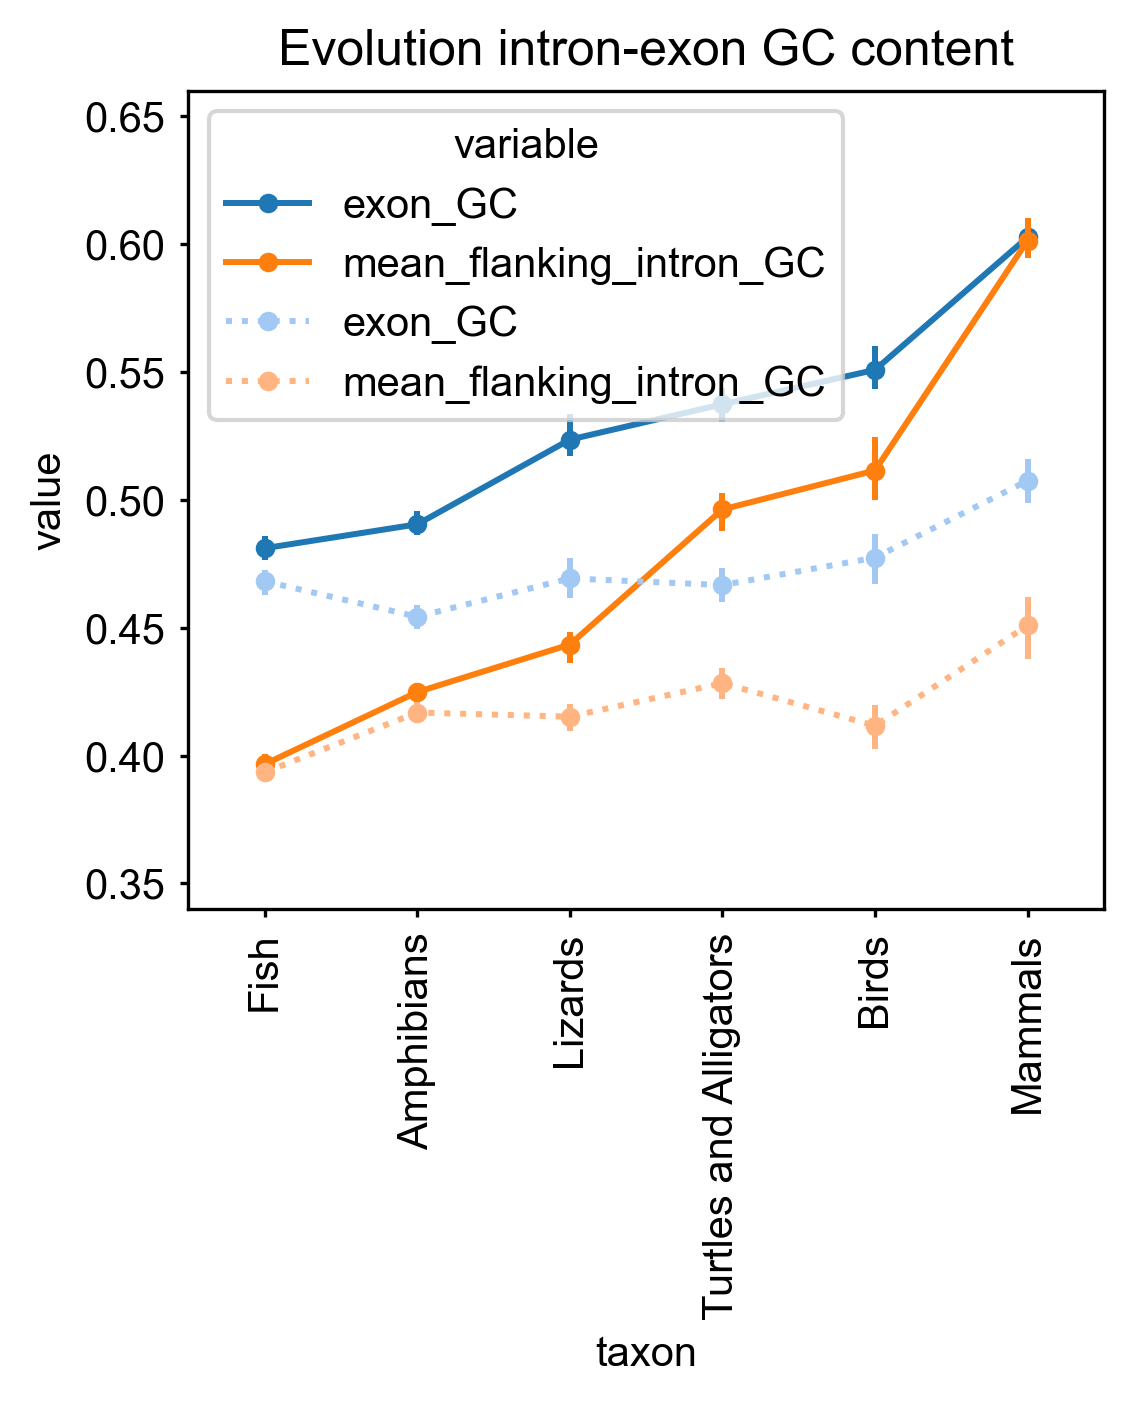

In [202]:
tmp = exons_df[[ 'exon_GC', 'mean_flanking_intron_GC', 'son_dependency', 'taxon' ]].copy()
tmp = tmp.melt(id_vars=[ 'son_dependency', 'taxon' ])

ax = sns.pointplot(data=tmp[tmp.son_dependency == 'SON-dependent'], x="taxon", y='value', hue='variable', order=taxa.keys(),
            errorbar=('ci', 99),
            estimator='median',
            linestyle='-')

ax = sns.pointplot(data=tmp[tmp.son_dependency == 'SON-independent'], x="taxon", y='value', hue='variable', order=taxa.keys(),
            palette='pastel',
            errorbar=('ci', 99),
            estimator='median',
            linestyle=":")
plt.xticks(rotation=90)
plt.ylim(0.34,0.66)

plt.title("Evolution intron-exon GC content")


Text(0.5, 1.0, 'Evolution intron-exon length')

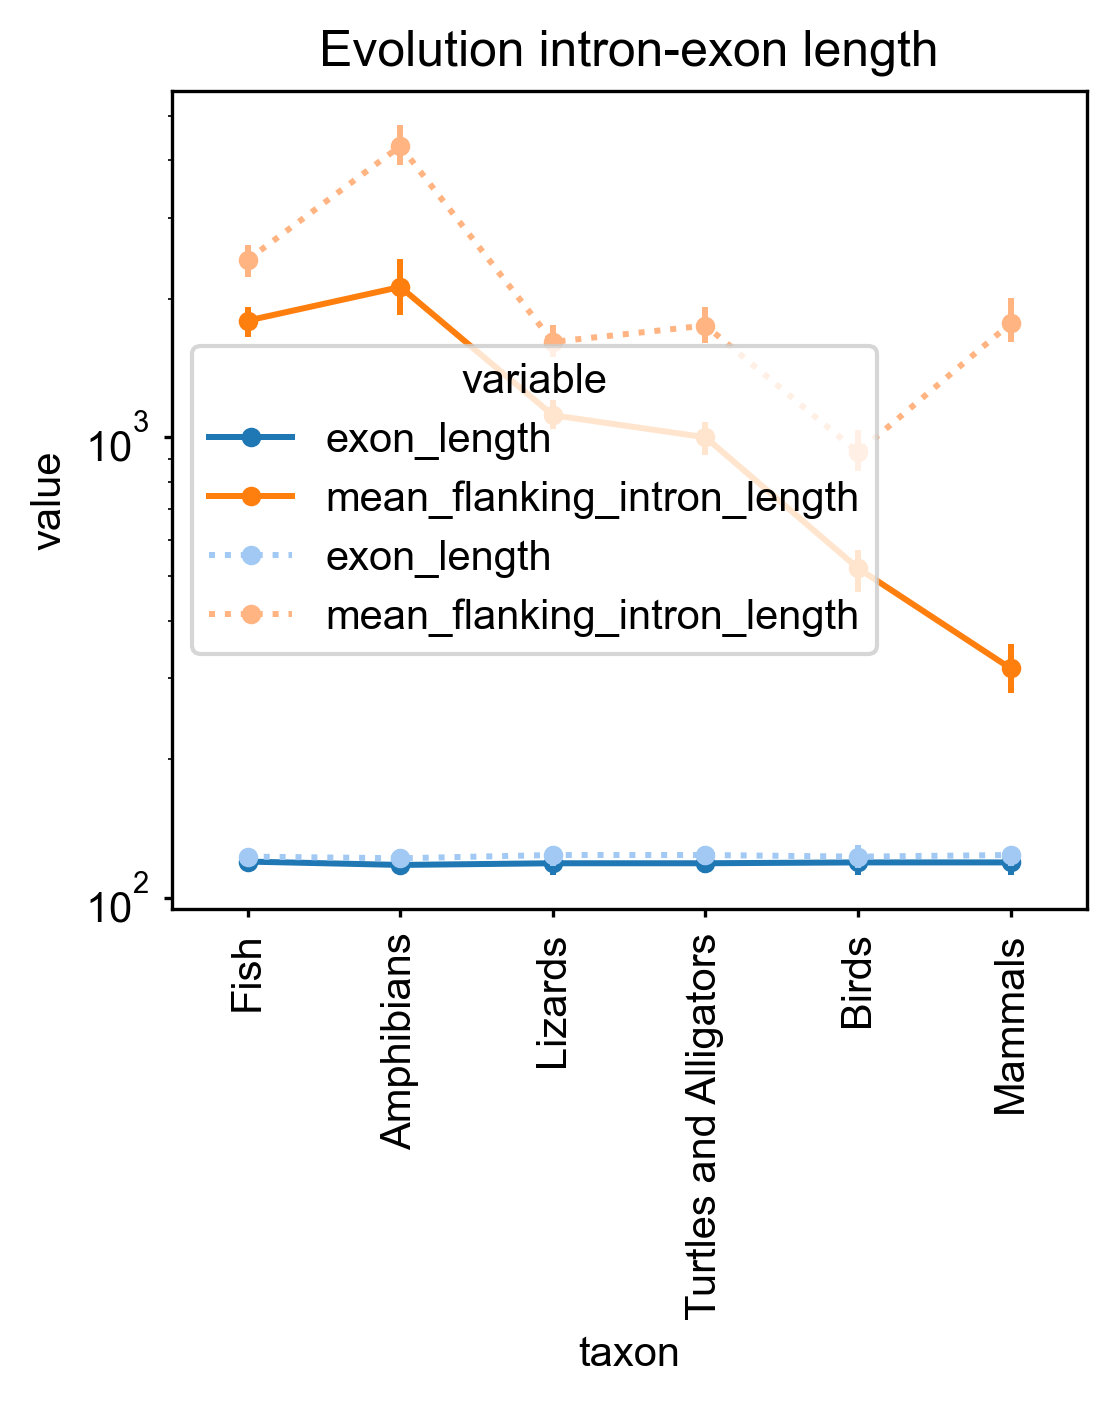

In [204]:
tmp = exons_df[[ 'exon_length', 'mean_flanking_intron_length', 'son_dependency', 'taxon' ]].copy()
tmp = tmp.melt(id_vars=[ 'son_dependency', 'taxon' ])

blue_palette = [sns.color_palette("pastel")[0],sns.color_palette()[0]]
orange_palette = [sns.color_palette()[1],sns.color_palette("pastel")[1]]

ax = sns.pointplot(data=tmp[tmp.son_dependency == 'SON-dependent'], x="taxon", y='value', hue='variable', order=taxa.keys(),
            log_scale=True, 
            errorbar=('ci', 99),
            estimator='median',
            linestyle='-')

ax = sns.pointplot(data=tmp[tmp.son_dependency == 'SON-independent'], x="taxon", y='value', hue='variable', order=taxa.keys(),
            log_scale=True, 
            palette='pastel',
            errorbar=('ci', 99),
            estimator='median',
            linestyle=":")
plt.xticks(rotation=90)

plt.title("Evolution intron-exon length")


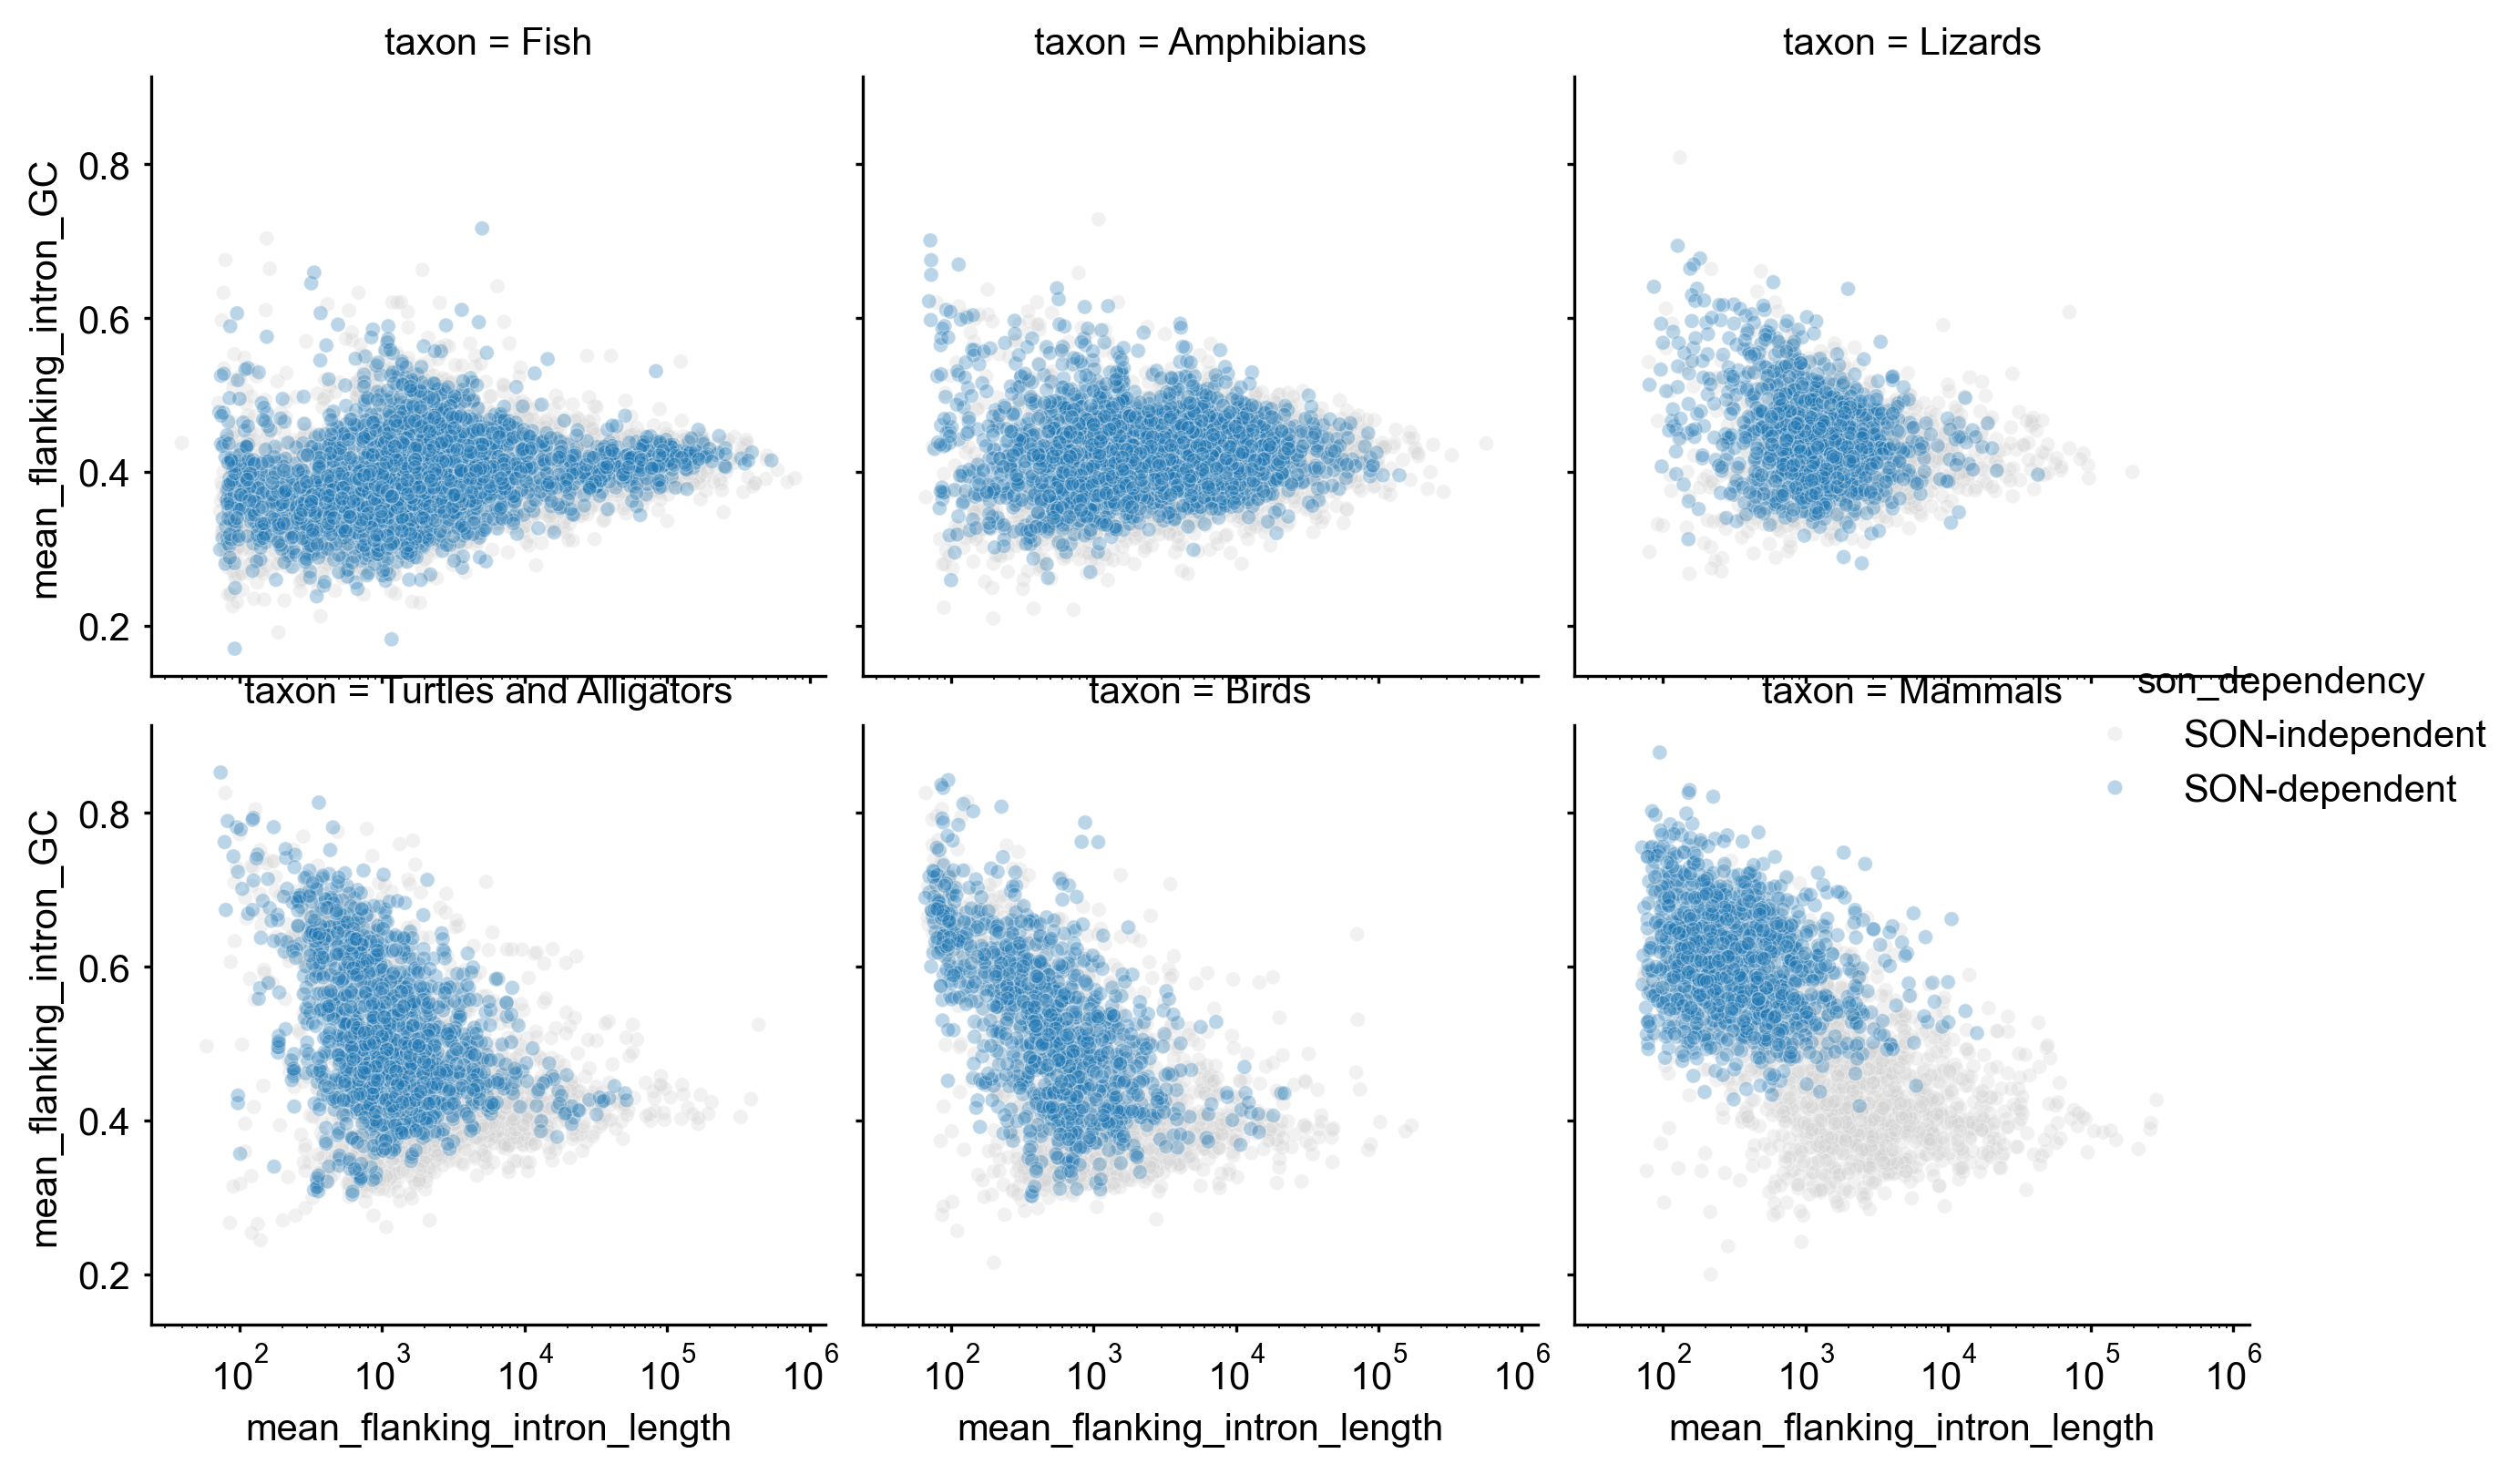

In [205]:
pal = ['lightgrey', sns.color_palette()[0]]

g = sns.relplot(data=exons_df.iloc[::-1], 
            y='mean_flanking_intron_GC', x='mean_flanking_intron_length', 
            hue='son_dependency', hue_order=("SON-independent", "SON-dependent"), palette=pal,
            col='taxon', col_order=taxa.keys(), col_wrap=3,
            s=15, alpha=.3,)
plt.xscale("log")

g.fig.set_size_inches(9, 5)

for ax in g.axes.flatten():
    for artist in ax.collections:
        artist.set_rasterized(True)

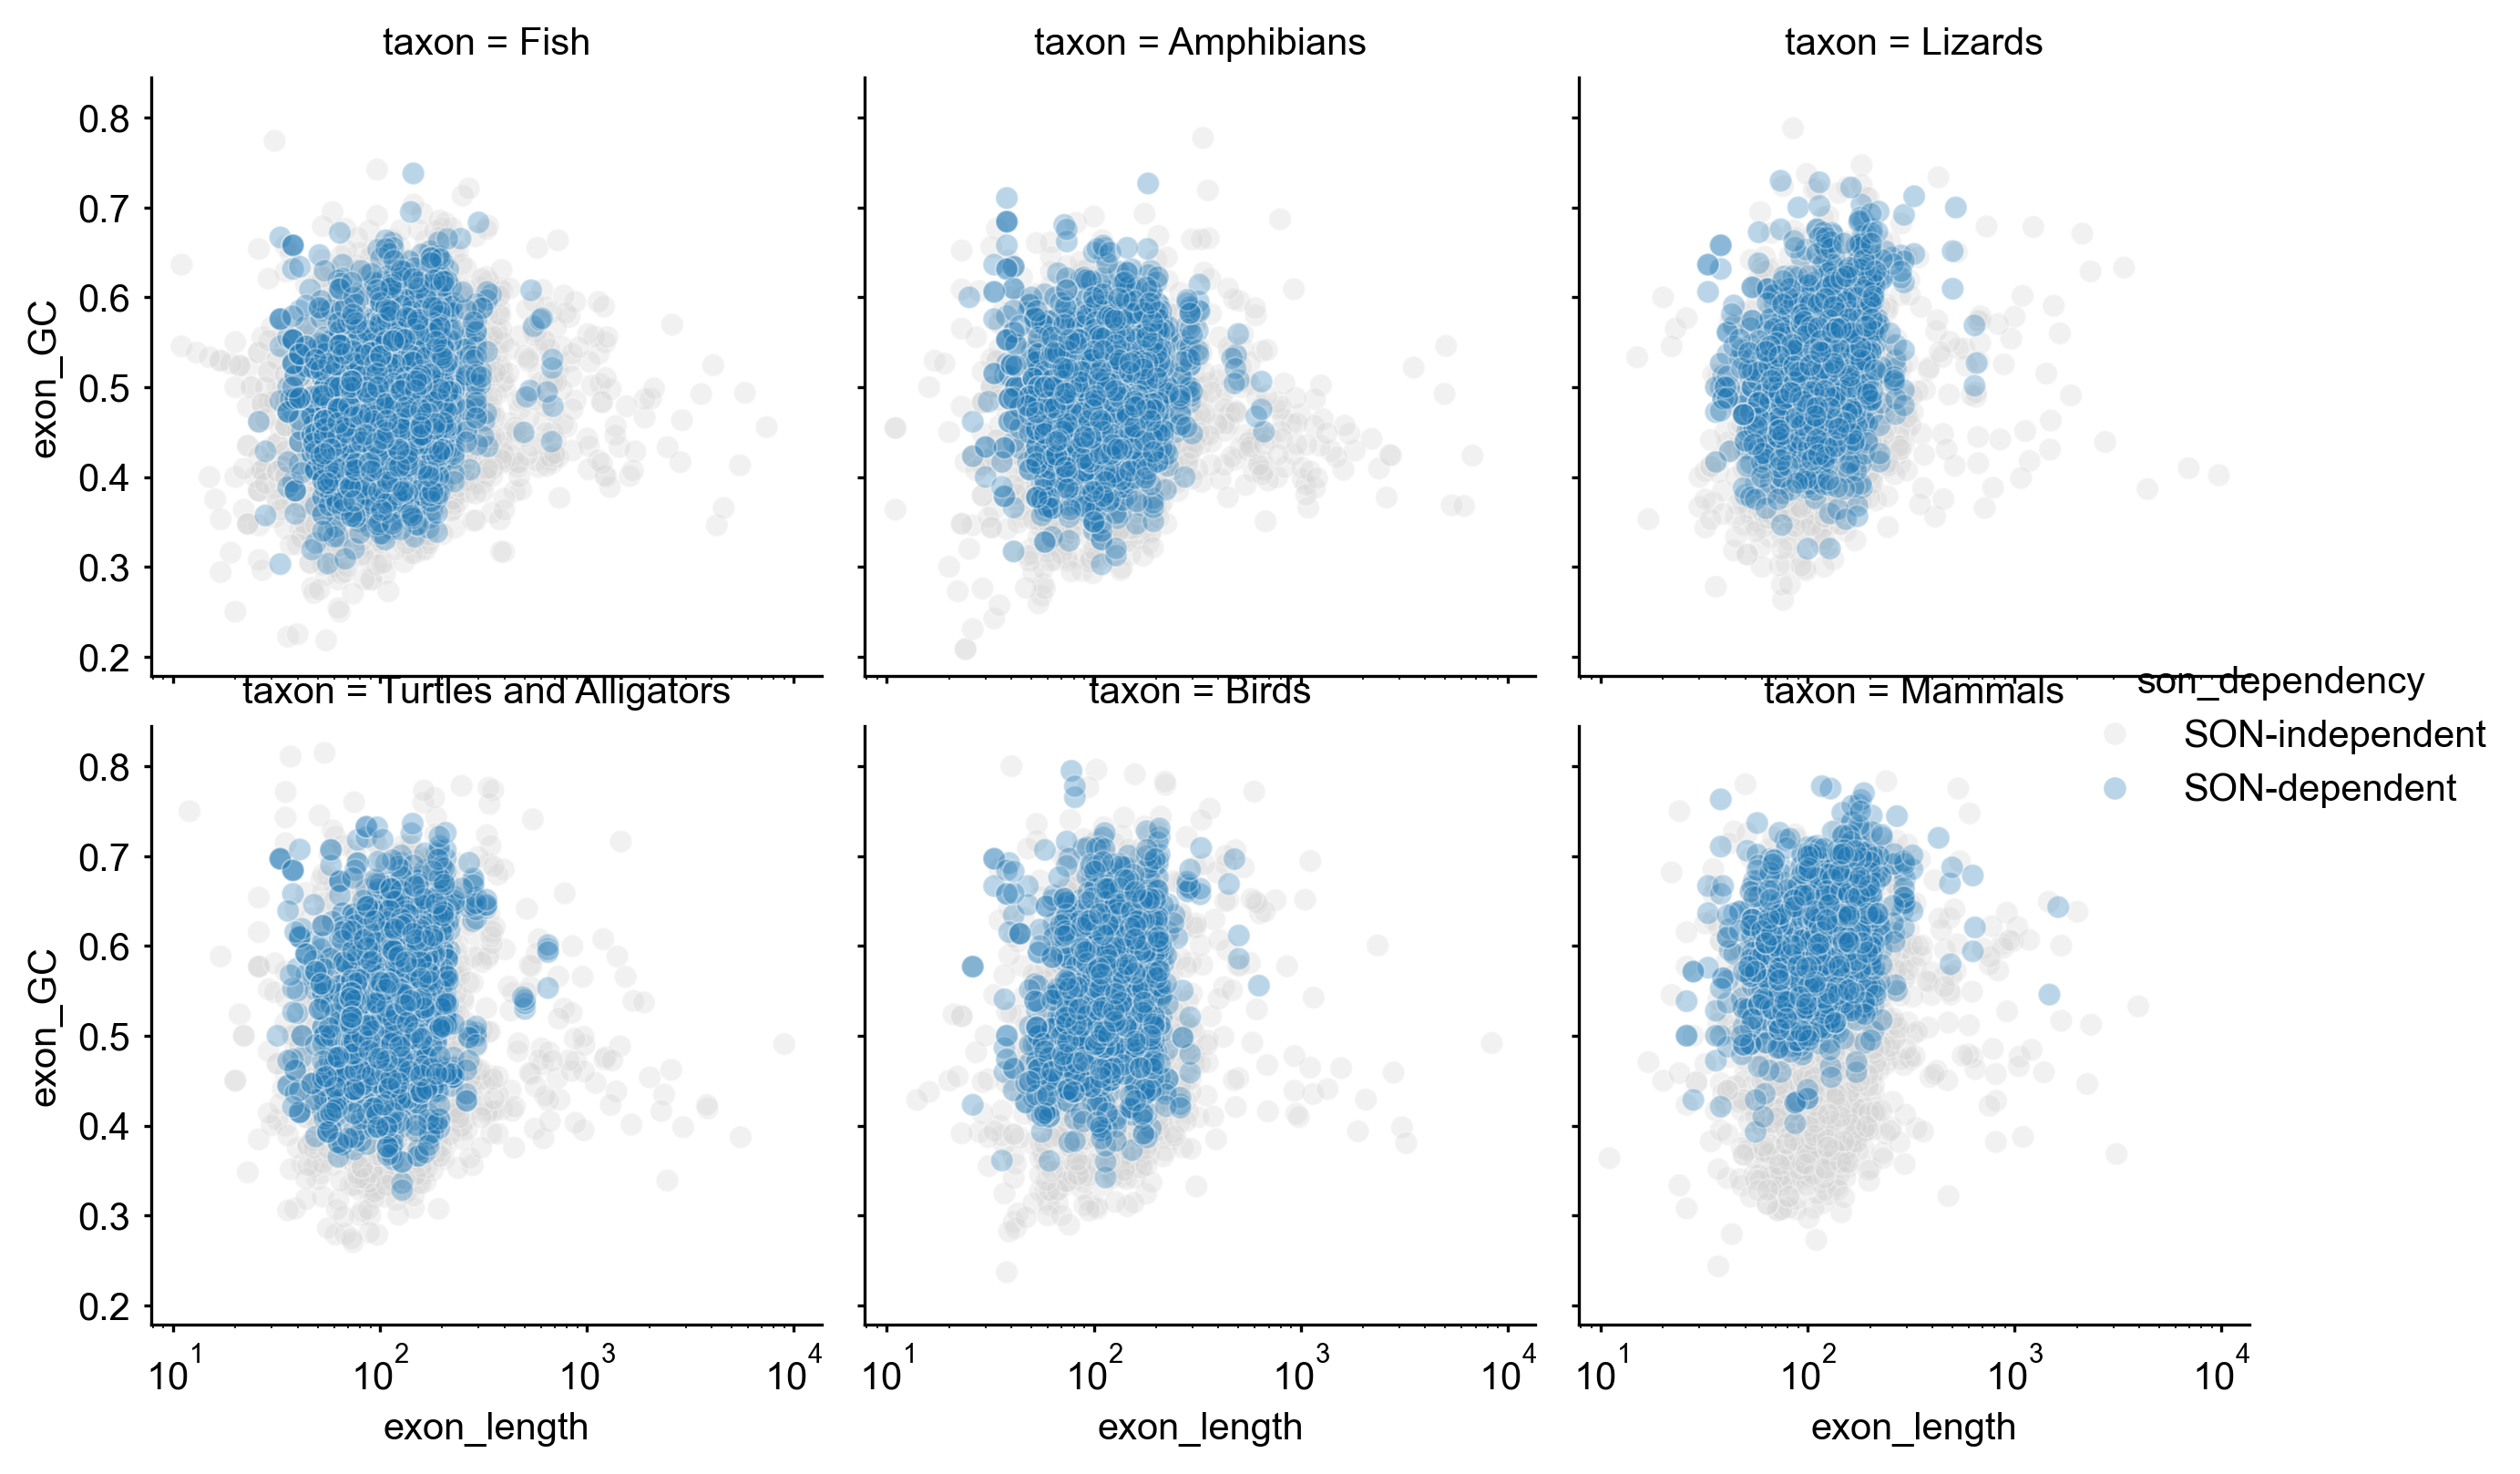

In [206]:
pal = ['lightgrey', sns.color_palette()[0]]

g = sns.relplot(data=exons_df.iloc[::-1], 
            y='exon_GC', x='exon_length', 
            hue='son_dependency', hue_order=("SON-independent", "SON-dependent"), palette=pal,
            col='taxon', col_order=taxa.keys(), col_wrap=3,
            s=35, alpha=.3)
plt.xscale("log")
g.fig.set_size_inches(9, 5)
for ax in g.axes.flatten():
    for artist in ax.collections:
        artist.set_rasterized(True)

In [207]:
for taxon in taxa.keys():
    print(taxon)
    tmp = exons_df[exons_df.taxon == taxon]
    for dep in ['SON-dependent', 'SON-independent']:
        print(dep, 'intron_len : ', stats.normaltest(tmp[tmp.son_dependency == dep].mean_flanking_intron_length))
        print(dep, 'intron_GC : ', stats.normaltest(tmp[tmp.son_dependency == dep].mean_flanking_intron_GC))
    print("\n")


Fish
SON-dependent intron_len :  NormaltestResult(statistic=3873.921173496773, pvalue=0.0)
SON-dependent intron_GC :  NormaltestResult(statistic=186.9680158774737, pvalue=2.514265904382624e-41)
SON-independent intron_len :  NormaltestResult(statistic=6120.7254739253685, pvalue=0.0)
SON-independent intron_GC :  NormaltestResult(statistic=336.2425333318828, pvalue=9.67969328756877e-74)


Amphibians
SON-dependent intron_len :  NormaltestResult(statistic=2358.6199660359284, pvalue=0.0)
SON-dependent intron_GC :  NormaltestResult(statistic=185.35764398372254, pvalue=5.624695542762971e-41)
SON-independent intron_len :  NormaltestResult(statistic=4557.150340887678, pvalue=0.0)
SON-independent intron_GC :  NormaltestResult(statistic=122.62677315635501, pvalue=2.3546943530664554e-27)


Lizards
SON-dependent intron_len :  NormaltestResult(statistic=1527.6399945786616, pvalue=0.0)
SON-dependent intron_GC :  NormaltestResult(statistic=93.93455835041274, pvalue=4.002854684363242e-21)
SON-independen

In [208]:
for taxon in taxa.keys():
    print(taxon)
    tmp = exons_df[exons_df.taxon == taxon]
    
    length = stats.mannwhitneyu(tmp[tmp.son_dependency == 'SON-independent'].mean_flanking_intron_length,
                                tmp[tmp.son_dependency == 'SON-dependent'].mean_flanking_intron_length)
    gc = stats.mannwhitneyu(tmp[tmp.son_dependency == 'SON-independent'].mean_flanking_intron_GC,
                                tmp[tmp.son_dependency == 'SON-dependent'].mean_flanking_intron_GC)
    
    print('intron_len : ', length)
    print('intron_GC : ', gc,'\n')

Fish
intron_len :  MannwhitneyuResult(statistic=7793660.5, pvalue=7.597840887381696e-18)
intron_GC :  MannwhitneyuResult(statistic=6786737.5, pvalue=0.03602825026578605) 

Amphibians
intron_len :  MannwhitneyuResult(statistic=4158091.0, pvalue=1.1484984284083424e-45)
intron_GC :  MannwhitneyuResult(statistic=2946557.0, pvalue=7.7150238887927515e-16) 

Lizards
intron_len :  MannwhitneyuResult(statistic=1087070.5, pvalue=1.822835749471136e-33)
intron_GC :  MannwhitneyuResult(statistic=637996.0, pvalue=9.73308454252589e-29) 

Turtles and Alligators
intron_len :  MannwhitneyuResult(statistic=2021591.0, pvalue=1.9205412069917936e-57)
intron_GC :  MannwhitneyuResult(statistic=928309.5, pvalue=1.5735050622336573e-91) 

Birds
intron_len :  MannwhitneyuResult(statistic=1097106.5, pvalue=3.5035822717877774e-48)
intron_GC :  MannwhitneyuResult(statistic=474519.5, pvalue=8.773089369870289e-76) 

Mammals
intron_len :  MannwhitneyuResult(statistic=1546598.0, pvalue=9.739402705028164e-204)
intron_GC 